# Relationship of disease and SNPs

Single Nucleotide Polymorphisms (SNPs) may be quantified as predictor variables in order to look for associations with a given phenotype, such as a disease. Investigate the dataset disease.arff containing genomic data on 2000 individuals, some of whom have the disease and some of whom do not. Each row contains data on one individual.

There are 10 predictor variables: these are SNPs encoded as number of mutated alleles for the gene. The class variable
indicates for each person whether they have disease (1 if they have it, zero if not).

In [98]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFECV, SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [99]:
pd.options.display.max_rows = 20
plt.figure(figsize=(16, 8))

## Preprocessing the data 

In [100]:
def arff2nparray(filepath):
    """Read arff file to pandas data frame. Skip header.

    Parameters
    ----------
    filepath: string of the file path

    Returns
    -------
    Numpy array of the data.
    """
    f = open(filepath, 'rb')
    dataset = loadarff(f)[0]
    f.close()
    return dataset

In [101]:
# Read in the .arff file and return a numpy record array
dataset = arff2nparray("disease2a.arff")
dataset

array([('1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0'),
       ('0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0'),
       ('0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0'), ...,
       ('1', '0', '0', '0', '1', '1', '1', '1', '2', '2', '0'),
       ('0', '1', '2', '1', '0', '0', '1', '0', '0', '2', '1'),
       ('1', '0', '0', '1', '1', '2', '0', '0', '0', '2', '0')], 
      dtype=[('location1', 'S1'), ('location2', 'S1'), ('location3', 'S1'), ('location4', 'S1'), ('location5', 'S1'), ('location6', 'S1'), ('location7', 'S1'), ('location8', 'S1'), ('location9', 'S1'), ('location10', 'S1'), ('class', 'S1')])

In [102]:
def split_dataset(data):
    """Split data set into training and testing data sets.

    Parameters
    ----------
    data: numpy.ndarray

    Returns
    -------
    A tuple of train and test subsets
    """
    features = np.hstack((data['location1'].astype(float).reshape(2000, 1), data['location2'].astype(float).reshape(2000, 1), 
           data['location3'].astype(float).reshape(2000, 1), data['location4'].astype(float).reshape(2000, 1),
           data['location5'].astype(float).reshape(2000, 1), data['location6'].astype(float).reshape(2000, 1),
           data['location7'].astype(float).reshape(2000, 1), data['location8'].astype(float).reshape(2000, 1),
           data['location9'].astype(float).reshape(2000, 1), data['location10'].astype(float).reshape(2000, 1)))
    outcome = data['class']
    features_train, features_test, outcome_train, outcome_test = \
        train_test_split(features, outcome, test_size=0.2, random_state=1)
    return features_train, features_test, outcome_train, outcome_test, features, outcome

In [103]:
# split the data into features(X) and outcome(y)
split_data = split_dataset(dataset)
X = split_data[4].astype(float)
y = split_data[5].astype(float)
y

array([ 0.,  0.,  0., ...,  0.,  1.,  0.])

In [104]:
# Split the data into train and test sets
X_train = split_data[0].astype(float)
X_test = split_data[1].astype(float)
y_train = split_data[2].astype(float)
y_test = split_data[3].astype(float)
print y_train

[ 0.  1.  1. ...,  0.  1.  0.]


In [105]:
# convert the data from numpy array to pandas data frame
pandas_data = pd.DataFrame(dataset)

In [106]:
# split the features from the pandas data frame
pandas_features = pandas_data.iloc[:, 0:10]

In [107]:
# make the data frame of features as numeric
pandas_features_num = pandas_features.apply(lambda x: pd.to_numeric(x, errors='ignore'))
pandas_features_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
location1     2000 non-null int64
location2     2000 non-null int64
location3     2000 non-null int64
location4     2000 non-null int64
location5     2000 non-null int64
location6     2000 non-null int64
location7     2000 non-null int64
location8     2000 non-null int64
location9     2000 non-null int64
location10    2000 non-null int64
dtypes: int64(10)
memory usage: 156.3 KB


In [108]:
#After reading in arff data to a numpy array of numpy array, but before the train/test split:
enc = OneHotEncoder()
data_hot_X = enc.fit(X) 
print data_hot_X
X_hot = data_hot_X.transform(X).toarray()

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)


In [109]:
# split the one-hot encoding data to training and testing data sets
X_hot_train, X_hot_test, y_train, y_test = train_test_split(X_hot, y, test_size=0.2, random_state=1)

## Summary Statistics

In [110]:
pandas_features.describe()

,location1,location2,location3,location4,location5,location6,location7,location8,location9,location10
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,3,3,3,3,3,3,3,3,3,3
top,0,0,1,0,1,1,0,0,0,1
freq,1025,1151,920,1319,1148,888,1148,1416,916,1166


In [111]:
pandas_features_num.describe()

,location1,location2,location3,location4,location5,location6,location7,location8,location9,location10
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.573500,0.483000,0.750000,0.380000,1.011000,0.688000,0.489000,0.317500,0.652500,0.981000
std,0.645605,0.605718,0.691187,0.561032,0.652757,0.677411,0.613243,0.517521,0.669304,0.645637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


## Histogram

Histogram only plots numerical data, so using numerical data set to plot the histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122154d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1206e9e10>]], dtype=object)

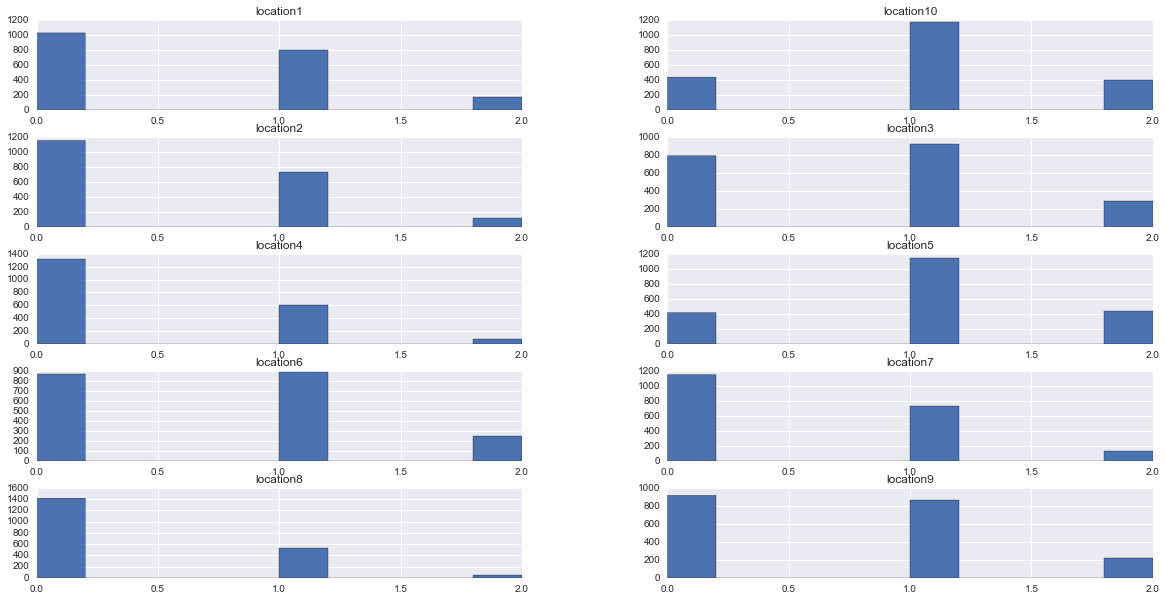

In [112]:
%matplotlib inline
sns.set_style("darkgrid")
pandas_features_num.hist(layout=(5,2), figsize=(20, 10))

Use the numerical data, we are able to calculate the correlations between the features and plot a heatmap for correlations.

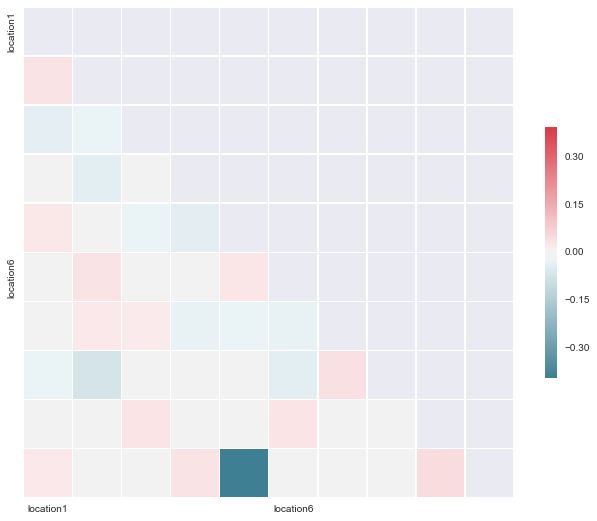

In [113]:
# Compute the correlation matrix
corr = pandas_features_num.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Random Forest

Use Random Forest to rank the variables. Also calculate the sensitivity, specificity, accuracy, f-score, and area under ROC curve.

Make a function for Random Forest classifier:

In [114]:
def RandomForest(X_train, X_test, y_train):
    """Compute a random forest classifier.

    Parameters
    ----------
    X_train:
        A numpy array of features from the training data set.
    X_test:
        A numpy array of features from the test data set.
    y_train:
        A numpy array of the outcomes from the training data set.

    Returns
    -------
    A tuple of the random forest classifier and a numpy array of the predicted
    label for the test data set.
    """
    randomforest_classifier = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

    # Perform classification on the test set
    predict = randomforest_classifier.predict(X_test)
    return randomforest_classifier, predict

Create functions for calculating sensitivity, specificity, accuracy, area under ROC curve, and f-score:

In [118]:
def confussion_mat(y_test, y_pred):
    """The function takes two parameters, a numpy array/matrix of the test data,
    and a numpy array of the predicted value of the test data.
    
    Given these inputs, you will calculate and return the confussion matrix of the
    classification.
    """
    cm = confusion_matrix(y_test, y_pred)
    return cm
    
def sensitivity(y_test, y_pred):
    """This function takes two parameters, a numpy array/matrix of the test data,
    and a numpy array of the predicted value of the test data.

    Given these inputs, you will calculate and return the sensitivity of the
    classification.

    Your function will return the calculated value as a float."""
    # Calculate confusion matrix and sensitivity of classification
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    sensitivity = float(tp) / float(tp + fn)
    return sensitivity


def specificity(y_test, y_pred):
    """This function takes two parameters, a numpy array/matrix of the test data,
    and a numpy array of the predicted value of the test data.

    Given these inputs, you will calculate and return the specificity of the
    classification.

    Your function will return the calculated value as a float."""
    # Calculate confusion matrix and sensitivity of classification
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = float(tn) / float(tn + fp)
    return specificity


def acc(y_test, y_pred):
    """Calculate the accuracy.

    Parameters
    ----------
    test_data: A numpy array of test dataset
    y_pred: a numpy array of the predicted target values for X_test.

    Returns
    -------
    numpy.float64 of the accuracy
    """
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


def auc(model, scaled_feature_test, outcome_test):
    """This function takes two parameters, the model (for the purpose of this assignment,
    this will be an instance of sklearn.svm.SVC and sklearn.linear_model.LogisticRegression), 
    and a numpy array/matrix of the test data.

    Given these inputs, you will calculate and return the area under the ROC
    curve of the classification.

    Your function will return the calculated value as a float."""
    # Apply model to predict confidence scores for samples
    y_score = model.decision_function(scaled_feature_test)

    # Calculate the area under the ROC curve
    area_under_roc = roc_auc_score(outcome_test, y_score)
    return area_under_roc


def auc_predict_proba(model, scaled_feature_test, outcome_test):
    """This function takes two parameters, the model (for the purpose of this assignment,
    this will be an instance of sklearn.ensemble.RandomForestClassifier), 
    and a numpy array/matrix of the test data.

    Given these inputs, you will calculate and return the area under the ROC
    curve of the classification.
    
    Your function will return the calculated value as a float."""
    # Apply model to predict confidence scores for samples
    y_score = model.predict_proba(scaled_feature_test)

    # Calculate the area under the ROC curve
    area_under_roc = roc_auc_score(outcome_test, y_score[:, 1])
    return area_under_roc


def f(y_pred, outcome_test, beta=1.0):
    """This function takes three parameters, the model, a numpy array/matrix
    of the test data, and a beta value to be used in calculating the F-score.

    Beta defaults to 1 if not specified (thus returning the F1 score)

    Given these inputs, you will caluclate and return the F score of the
    classification. 
    
    Your function will return the calculated value as a float."""
    # Calculate the confusion matrix and the F score of the classification
    cm = confusion_matrix(outcome_test, y_pred)
    tp = float(cm[1, 1])
    fn = float(cm[1, 0])
    fp = float(cm[0, 1])

    f_score = (float(1 + beta ** 2) * tp) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp)
    return f_score


Using numerical data to do the feature ranking:

In [119]:
# Random Forest
random_forest = RandomForest(X_train, X_test, y_train)
estimator_rf = random_forest[0]
y_predict_rf = random_forest[1]
feature_importance = estimator_rf.feature_importances_
n_feature = estimator_rf.n_features_

# Calculate the accuracy, sensitivity, specificity, f1-score, and AUC
accurate_rf = acc(y_test, y_predict_rf)
sen_rf = sensitivity(y_test, y_predict_rf)
spec_rf = specificity(y_test, y_predict_rf)
f1_rf = f(y_predict_rf, y_test)
area_under_roc_rf = auc_predict_proba(estimator_rf, X_test, y_test)

print 'Random Forest:'
print 'The accuracy is: %s' % accurate_rf
print 'The sensitivity is: %s' % sen_rf
print 'The specificity is: %s' % spec_rf
print 'The F1 score is: %s' % f1_rf
print 'The AUC is: %s' % area_under_roc_rf
print 'The number of features when fit is performed: %s' % n_feature
print

indice = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("Feature Ranking (Random Forest):")

for feature in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (feature + 1, indice[feature], feature_importance[indice[feature]]))


Random Forest:
The accuracy is: 0.7825
The sensitivity is: 0.86976744186
The specificity is: 0.681081081081
The F1 score is: 0.811279826464
The AUC is: 0.808120678818
The number of features when fit is performed: 10

Feature Ranking (Random Forest):
1. feature 9 (0.231778)
2. feature 4 (0.225769)
3. feature 2 (0.079690)
4. feature 8 (0.076773)
5. feature 1 (0.071461)
6. feature 5 (0.066344)
7. feature 6 (0.064886)
8. feature 0 (0.062155)
9. feature 3 (0.061840)
10. feature 7 (0.059304)


From the results, location 5, location 10, and location 3 are the most important three features.

Feed in the catogorical (one-hot) data to implement the random forest classifier:

In [123]:
# Random Forest
random_forest = RandomForest(X_hot_train, X_hot_test, y_train)
estimator_rf = random_forest[0]
y_predict_rf = random_forest[1]
n_feature = estimator_rf.n_features_

# Calculate the accuracy, sensitivity, specificity, f1-score, and AUC
accurate_rf = acc(y_test, y_predict_rf)
sen_rf = sensitivity(y_test, y_predict_rf)
spec_rf = specificity(y_test, y_predict_rf)
f1_rf = f(y_predict_rf, y_test)
area_under_roc_rf = auc_predict_proba(estimator_rf, X_hot_test, y_test)

print 'Random Forest:'
print 'The accuracy is: %s' % accurate_rf
print 'The sensitivity is: %s' % sen_rf
print 'The specificity is: %s' % spec_rf
print 'The F1 score is: %s' % f1_rf
print 'The AUC is: %s' % area_under_roc_rf
print 'The number of features when fit is performed: %s' % n_feature
print

Random Forest:
The accuracy is: 0.7775
The sensitivity is: 0.860465116279
The specificity is: 0.681081081081
The F1 score is: 0.806100217865
The AUC is: 0.81795097423
The number of features when fit is performed: 30



Confusion matrix, without normalization
[[126  59]
 [ 30 185]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.14  0.86]]


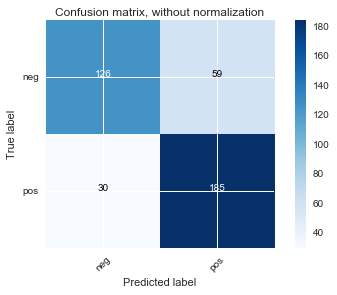

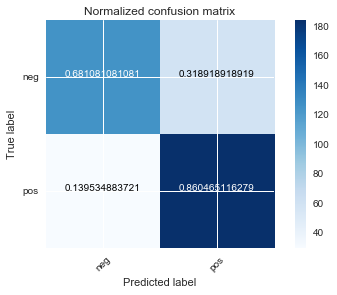

In [125]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The results of random forest from both numerical features and categorical features are very similar. Both have accuracy close to 0.77 and AUC close to 0.80.

Plot the ROC curve for Random Forest:

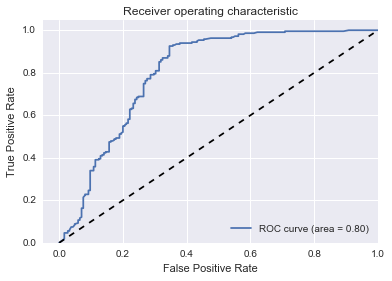

In [73]:
# Calculate the decision function of test set
y_score = estimator_rf.predict_proba(X_hot_test)
y_true = y_test

# Calculate the false positive rate,  the true positive rate and the area
# under ROC curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_true, y_score[:, 1])
roc_auc = roc_auc_score(y_true, y_score[:, 1])

# Plot
plt.plot(fpr_rf, tpr_rf, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot black dashed line (k=black) from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--')

# Set x and y ranges, labels, title and legend
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
# plot_roc(estimator_rf, X_hot_test, y_test)

## Support Vector Machine (SVM)

Use grid search to get the best parameters:

In [34]:
def svm_grid_search(X, y, parameters):
    """Use GridSearchCV to find the "best" SVM classifier.

    Parameters
    ----------
    X:
        A numpy array of the features from training data set.
    y:
        A numpy array of the outcomes from training data set.
    parameters:
        A python dictionary of the parameters using to build the svm model. 

    Returns
    -------
    A dictionary of the parameters of the best SVM classifier.
    """
    cv = KFold(n_splits=5, random_state=1)
    clf = GridSearchCV(SVC(), parameters, n_jobs=-1, cv=cv)
    clf.fit(X, y)
    best_clf = clf.best_params_
    return best_clf

* Find out the best parameters for SVM with rbf kernel

In [35]:
t0 = time.time()
# Use GridSearchCV to find the "best" SVM classifier for rbf kernel
parameters = [{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10],
                   'gamma': [0.001, 0.01, 0.1, 1]}]
best_rbf = svm_grid_search(X_hot_train, y_train, parameters)
computing_time = time.time() - t0
print 'The computing time for gird search is: %s' % computing_time
print 'The best SVM classifier is: %s' % best_rbf

The computing time for gird search is: 5.5096487999
The best SVM classifier is: {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}


* Find out the best parameters for SVM with poly kernel

In [39]:
t0 = time.time()
# Use GridSearchCV to find the "best" SVM classifier for polynominal kernel, degree 2, C=1
parameters = [{'kernel': ['poly'], 'C': [0.01, 0.1, 1, 10],
                   'gamma': [0.001, 0.01, 0.1, 1],
                   'degree': [2]}]
best = svm_grid_search(X_hot_train, y_train, parameters)
computing_time = time.time() - t0
print 'The computing time for gird search is: %s' % computing_time
print 'The best SVM classifier for polynominal kernel of degree 2, C=1 is: %s' % best

The computing time for gird search is: 35.6751849651
The best SVM classifier for polynominal kernel of degree 2, C=1 is: {'kernel': 'poly', 'C': 0.01, 'gamma': 1, 'degree': 2}


In [40]:
t0 = time.time()
# Use GridSearchCV to find the "best" SVM classifier for polynominal kernel, degree 3
parameters = [{'kernel': ['poly'], 'C': [0.01, 0.1, 1, 10],
                   'gamma': [0.001, 0.01, 0.1, 1],
                   'degree': [3]}]
best = svm_grid_search(X_hot_train, y_train, parameters)
computing_time = time.time() - t0
print 'The computing time for gird search is: %s' % computing_time
print 'The best SVM classifier for polynominal kernel of degree 3 is: %s' % best

The computing time for gird search is: 30.1736979485
The best SVM classifier for polynominal kernel of degree 3 is: {'kernel': 'poly', 'C': 1, 'gamma': 0.1, 'degree': 3}


In [42]:
t0 = time.time()
# Use GridSearchCV to find the "best" SVM classifier for polynominal kernel, degree 3
parameters = [{'kernel': ['poly'], 'C': [0.01, 1],
                   'gamma': [0.1, 1],
                   'degree': [2, 3]}]
best_poly = svm_grid_search(X_hot_train, y_train, parameters)
computing_time = time.time() - t0
print 'The computing time for gird search is: %s' % computing_time
print 'The best SVM classifier for polynominal kernel: %s' % best_poly

The computing time for gird search is: 8.3379778862
The best SVM classifier for polynominal kernel: {'kernel': 'poly', 'C': 0.01, 'gamma': 1, 'degree': 2}


Create functions to use a support vector machine (SVM) and two different kernels (rbf and polynomial). 

In [61]:
def RBF_SVM(X_train, X_test, y_train, C, gamma):
    """Compute the C-Support Vector Classification when kernel='rbf'.

    Parameters
    ----------
    X_train: 
        numpy array of scaled features from training data set
    X_test: 
        numpy array of scaled features from test data set
    y_train: 
        numpy array of outcome from training data set
    C: 
        float, optional (default=1.0). Penalty parameter C of the error term.
    gamma: 
        float, optional (default=’auto’). Kernel coefficient 
        for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then
        1/n_features will be used instead.

    Returns
    -------
    A tuple of fitted model and prediction of the test set.
    """
    clf = SVC(kernel='rbf', C=C, gamma=gamma).fit(X_train, y_train)
    predict = clf.predict(X_test)
    return clf, predict


def svm_poly(X_train, X_test, y_train, C, gamma):
    """Compute the C-Support Vector Classification.

    Parameters
    ----------
    X_train: numpy array of scaled features from training data set
    X_test: numpy array of scaled features from test data set
    y_train: numpy array of outcome from training data set
    C: float, penalty parameter C of the error term.
    gamma: float, kernel coefficient for 'rbf', 'poly' and 'sigmoid'.

    Returns
    -------
    A tuple of fitted model and prediction of the test set.
    """
    svc_clf = SVC(kernel='poly', C=C, gamma=gamma).fit(X_train, y_train)
    predict = svc_clf.predict(X_test)
    return svc_clf, predict

In [64]:
## RBF SVM
rbf_clf = RBF_SVM(X_hot_train, X_hot_test, y_train, C=best_rbf['C'], gamma=best_rbf['gamma'])
estimator_rbf = rbf_clf[0]
y_predict_rbf = rbf_clf[1]

# Calculate the accuracy, sensitivity, specificity, f1-score, and AUC
accurate_rbf = acc(y_test, y_predict_rbf)
sen_rbf = sensitivity(y_test, y_predict_rbf)
spec_rbf = specificity(y_test, y_predict_rbf)
f1_rbf = f(y_predict_rbf, y_test)
area_under_roc_rbf = auc(estimator_rbf, X_hot_test, y_test)

print
print 'RBF SVM:'
print 'The accuracy is: %s' % accurate_rbf
print 'The sensitivity is: %s' % sen_rbf
print 'The specificity is: %s' % spec_rbf
print 'The F1 score is: %s' % f1_rbf
print 'The AUC is: %s' % area_under_roc_rbf


RBF SVM:
The accuracy is: 0.8025
The sensitivity is: 0.948837209302
The specificity is: 0.632432432432
The F1 score is: 0.837782340862
The AUC is: 0.775964802011


Compute confusion matrix for SVM with rbf kernel

Confusion matrix, without normalization
[[117  68]
 [ 11 204]]
Normalized confusion matrix
[[ 0.63  0.37]
 [ 0.05  0.95]]


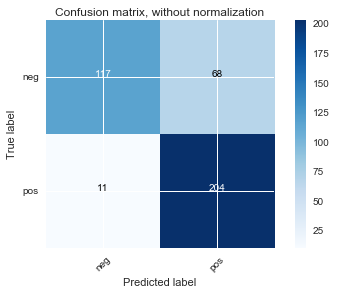

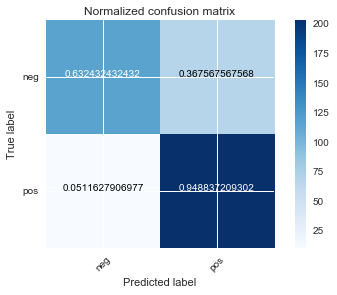

In [126]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_rbf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [62]:
## SVM Poly
svc_clf = svm_poly(X_hot_train, X_hot_test, y_train, C=best_poly['C'], gamma=best_poly['gamma'])
estimator = svc_clf[0]
y_predict = svc_clf[1]

# Calculate the accuracy, sensitivity, specificity, f1-score, and AUC
accurate = acc(y_test, y_predict)
sen = sensitivity(y_test, y_predict)
spec = specificity(y_test, y_predict)
f1 = f(y_predict, y_test)
area_under_roc = auc(estimator, X_hot_test, y_test)

print 'Poly SVC:'
print 'The accuracy is: %s' % accurate
print 'The sensitivity is: %s' % sen
print 'The specificity is: %s' % spec
print 'The F1 score is: %s' % f1
print 'The AUC is: %s' % area_under_roc

Poly SVC:
The accuracy is: 0.7675
The sensitivity is: 0.879069767442
The specificity is: 0.637837837838
The F1 score is: 0.802547770701
The AUC is: 0.79024512885


Compute confusion matrix for SVM with poly kernel

Confusion matrix, without normalization
[[118  67]
 [ 26 189]]
Normalized confusion matrix
[[ 0.64  0.36]
 [ 0.12  0.88]]


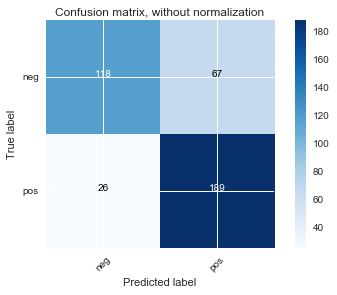

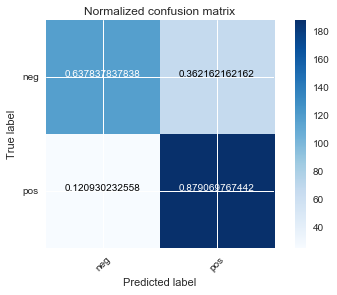

In [127]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

From the results of support vector machine, we can see that the rbf kernel has a higher accuracy, but the poly kernel has a higher AUC. However, the results from both models do no show a big difference.

In [55]:
def plot_roc(model, scaled_feature_test, outcome_test):
    """This function takes two parameters, the model, and a numpy array/matrix
    of the test data.

    1. Plot the false positive rate against the true positive rate
    2. Plot a straight line from the point (0,0) to (1,1)
    3. Set the X axis to the range [-0.05, 1]
    4. Set the Y axis to the range [0, 1.05]
    5. Add X axis label of "False Positive Rate"
    6. Add Y axis label of "True Positive Rate"
    7. Add a label "ROC curve (area = XX)" for the FPR/TPR plot
    8. Position the label at the lower right corner
    9. Add a title of your choosing
    10. Call show() to display your plot"""
    
    # Calculate the decision function of test set
    y_score = model.decision_function(scaled_feature_test)
    y_true = outcome_test

    # Calculate the false positive rate,  the true positive rate and the area
    # under ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(outcome_test, y_score)

    # Plot
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

    # Plot black dashed line (k=black) from (0,0) to (1,1)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set x and y ranges, labels, title and legend
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Plot a ROC curve for SVM with rbf kernel:

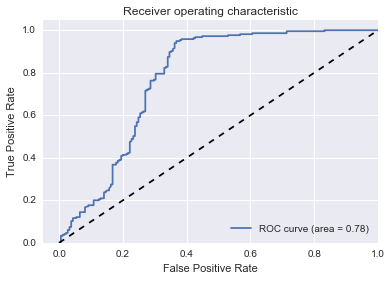

In [79]:
# Calculate the decision function of test set
y_score = estimator_rbf.decision_function(X_hot_test)
y_true = y_test

# Calculate the false positive rate,  the true positive rate and the area
# under ROC curve
fpr_rbf, tpr_rbf, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot
plt.plot(fpr_rbf, tpr_rbf, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot black dashed line (k=black) from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--')

# Set x and y ranges, labels, title and legend
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

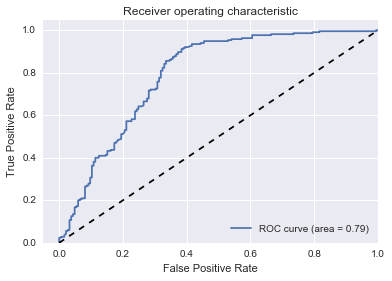

In [81]:
# Calculate the decision function of test set
y_score = estimator.decision_function(X_hot_test)
y_true = y_test

# Calculate the false positive rate,  the true positive rate and the area
# under ROC curve
fpr_poly, tpr_poly, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot
plt.plot(fpr_poly, tpr_poly, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot black dashed line (k=black) from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--')

# Set x and y ranges, labels, title and legend
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Plot a ROC curve for SVM with poly kernel:

## Regression Model

Use logistic regression to build the regression classifier:

In [69]:
def log_regression(X_train, X_test, y_train):
    """Compute the logistic regression model.

    Parameters
    ----------
    scaled_feature_train: numpy.ndarray
        A numpy array of the scaled features from training data set.
    scaled_feature_test: numpy.ndarray
        A numpy array of the scaled features from test data set.
    outcome_train:
        A numpy array of the outcomes from test data set.

    Returns
    -------
    A python tuple of a model and a numpy.ndarray
        A model of Logistic regression and a numpy array of the
        predicted target values for scaled_feature_test.

    """
    # Fit Logistic Regression according to the given training data.
    logreg = LogisticRegression().fit(X_train, y_train)

    # Perform classification on the test set
    predict = logreg.predict(X_test)
    return logreg, predict

In [70]:
log_clf = log_regression(X_hot_train, X_hot_test, y_train)
estimator_log = log_clf[0]
y_predict_log = log_clf[1]

# Calculate the accuracy, sensitivity, specificity, f1-score, and AUC
accurate_log = acc(y_test, y_predict_log)
sen_log = sensitivity(y_test, y_predict_log)
spec_log = specificity(y_test, y_predict_log)
f1_log = f(y_predict_log, y_test)
area_under_roc_log = auc(estimator_log, X_hot_test, y_test)

print
print 'Logistic regression:'
print 'The accuracy is: %s' % accurate_log
print 'The sensitivity is: %s' % sen_log
print 'The specificity is: %s' % spec_log
print 'The F1 score is: %s' % f1_log
print 'The AUC is: %s' % area_under_roc_log


Logistic regression:
The accuracy is: 0.55
The sensitivity is: 0.651162790698
The specificity is: 0.432432432432
The F1 score is: 0.608695652174
The AUC is: 0.544965430547


Plot the ROC curve for the logistic regression classifier:

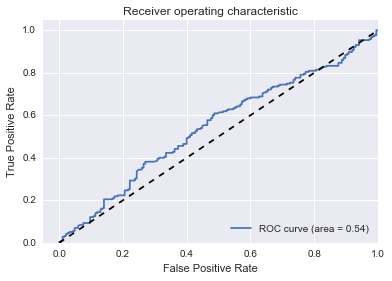

In [82]:
# Calculate the decision function of test set
y_score = estimator_log.decision_function(X_hot_test)
y_true = y_test

# Calculate the false positive rate,  the true positive rate and the area
# under ROC curve
fpr_log, tpr_log, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot
plt.plot(fpr_log, tpr_log, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot black dashed line (k=black) from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--')

# Set x and y ranges, labels, title and legend
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Compute confusion matrix for logistic regression:

Confusion matrix, without normalization
[[ 80 105]
 [ 75 140]]
Normalized confusion matrix
[[ 0.43  0.57]
 [ 0.35  0.65]]


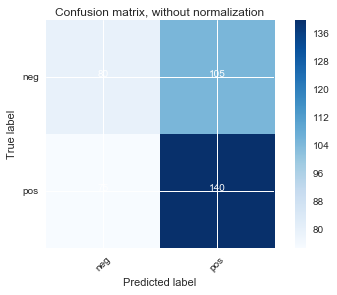

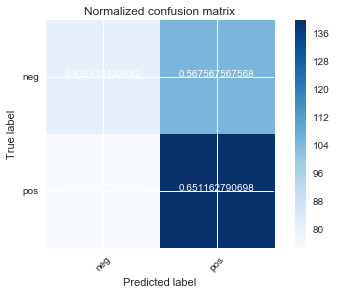

In [128]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_log)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Compare three ROC curves on the same plot:

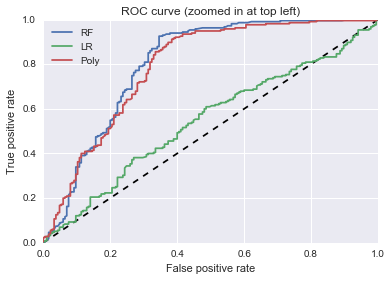

In [83]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_log, tpr_log, label='LR')
plt.plot(fpr_poly, tpr_poly, label='Poly')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

Use a bar chart to show the accuracy of different classifiers:

([<matplotlib.axis.XTick at 0x1265d4c50>,
 <a list of 4 Text xticklabel objects>)

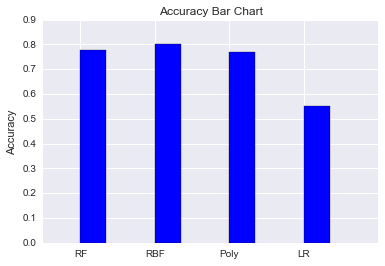

In [144]:
N = 4
accuracy_arr = (accurate_rf, accurate_rbf, accurate, accurate_log)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ['RF', 'RBF', 'Poly', 'LR']

plt.bar(ind, accuracy_arr, width, color='b')

# add some text for labels, title and axes ticks
plt.ylabel('Accuracy')
plt.title('Accuracy Bar Chart')
plt.xlim([-0.5, 4])
plt.xticks(ind, labels)


The neural network classifier shows a accuracy of 0.8025, which is the highest accuracy among all the classifiers (SVM using rbf kernel is the second one).